# Satellite Data 

**How to use script:**
1. **Specify desired date**
   - Date Format *1*: `day/month/year`  --> 290515 for May 29th 2015
   - Date Format *2*: `year/month/day`  --> 20150529 for May 29th 2015 <p>

2. **Directories with SoCal Coastal Relief Map and GPS data**
   - Link for GPS data: http://wimsoft.com/CAL/files/
   - Link for SoCal data: https://www.geoplatform.gov/metadata/1f9d35ae-ef0b-43c8-8657-e0de4c55a7e8
  
**GPS Data is required**

In [46]:
# ----- Edit Code HERE ----- #
date = '20150529'

# Location of depth data
fname = './crm_socal_1as_vers2.nc'
# Location of GPS data for Sat Data
gps_filename = './cal_aco_3840_Latitude_Longitude.hdf'

# Parameters #
window_size = 25

# Treating Data #
rmv_nan = True
rmv_mdr = False

# Plotting (temp files) #
# cruise track 
plot_track = True
# bathymetry
plot_bath  = True
# land features
plot_land  = True

# Save options #
saveplots = False


#### Employed Libraries

In [48]:
# satellite data upload
import requests 
import tempfile
import tables
from io import BytesIO
import os
# Functions 
import pyhdf as hp
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
# Zodiac data
import pickle
import revisedZodiacFunctions as zf

### Pre Step

In [50]:
# ------- GPS DATA ------- #

# Open the HDF4 file in read mode
hdf_file = SD(gps_filename, SDC.READ)

# List all available datasets in the HDF4 file
datasets = hdf_file.datasets()

# Access a specific dataset (replace 'dataset_name' with actual dataset name)
lat_dataset = hdf_file.select('Latitude')
lon_dataset = hdf_file.select('Longitude')

# Read data from the selected dataset
lat = lat_dataset.get()
lon = lon_dataset.get()

# Bound and set 1D arrays for colormesh plotting 
lat  = lat[1350:1410,1780:1885]
lon  = lon[1350:1410,1780:1885]
longitude = np.linspace(np.min(lon), np.max(lon), lon.shape[1])
latitude = np.linspace(np.min(lat), np.max(lat), len(lat))

# Close the HDF4 file after use
hdf_file.end()

In [52]:
# ------- Depth/Land DATA ------- #

if plot_land and plot_bath:

    from netCDF4 import Dataset, num2date
    
    nc = Dataset(fname)
    
    res = 2
    
    lon, lat = np.array(nc.variables['lon'][::res]), np.array(nc.variables['lat'][::res])
    depths = np.array(nc.variables['Band1'][::res, ::res])
    
    lon_min = np.where((lon <= -118.25) & (lon > -118.85))[0][-1]
    lon_max = np.where((lon <= -118.25) & (lon > -118.85))[0][0]
    lat_min = np.where((lat >= 33.5) & (lat < 34.15))[0][0]
    lat_max = np.where((lat >= 33.5) & (lat < 34.15))[0][-1]
    
    depths = depths[lat_min:lat_max, lon_max:lon_min]
    
    lon_bath    = lon[lon_max:lon_min]
    lat_bath    = lat[lat_min:lat_max]
    
    lon_bath, lat_bath = np.meshgrid(lon_bath, lat_bath)

### 1. Individual Cruise w/ Satellite Coverage

In [54]:
# ------- Cruise DATA ------- #

with open('track_data.pkl', 'rb') as ztd:
    zodiac_track_data = pickle.load(ztd)

try:
    # FUNCTION WILL GRAB DICTIONARY WITH CORREPSONDING DATE AND REMOVE NANS AS WELL AS ENSURE DATA IS IN DEFINED BOUNDS OF SMB - EXCLUDING MARINA
    specific_track, lat, lon, SST, flu = zf.track_selector(date, zodiac_track_data, excludenans=rmv_nan, excludemdr=rmv_mdr)
    print('Cruise data found')
    # Data Processing, Filtering, & Gradients for SST #
    dist_processed, sst_processed = zf.data_processing(lat, lon, SST, 10)
    grad_dist_sst, grad_sst, lat_sst, lon_sst, sst_filtered, dist_filtered = \
    zf.running_avg_filter(window_size, lat, lon, sst_processed, dist_processed)
    print('SST filtered...')
    # Data Processing, Filtering, & Gradients for Flu #
    dist_processed, flu_processed = zf.data_processing(lat, lon, flu, 10)
    grad_dist_flu, grad_flu, grad_lat_flu, grad_lon_flu, flu_filtered, dist_filtered = \
    zf.running_avg_filter(window_size, lat, lon, flu_processed, dist_processed)
    print('Flu filtered...')
except:
    plot_track = False
    pass

In [56]:
# ------- Generate URL ------- #

# from date, determine day of year 
days_in_month = [31, 60, 91, 120, 151, 181, 212, 243, 273, 304, 334, 365]

leap_year = 0
if len(date) == 6:
    year  = str(int(date[4:6]) + 2000)
    month = date[2:4]
    day   = date[0:2]
else:
    year  = date[0:4]
    month = date[4:6]
    day   = date[6:9]

if (int(year) % 4) == 0:
    leap_year = 1

if int(month) != 1:
    day_of_year = str(days_in_month[np.abs(int(month) - 2)] + int(day) + leap_year)
else:
    day_of_year = str(int(day) + leap_year)

print(year, month, day, day_of_year)

# url 
if (int(day_of_year) < 100):
    url = f"https://spg-satdata.ucsd.edu/{year}/M{year}_{type}_day/M{year}0{day_of_year}_{type}_comp.hdf"
else:
    url = f"https://spg-satdata.ucsd.edu/{year}/M{year}_{type}_day/M{year}{day_of_year}_{type}_comp.hdf"

print(url)

2015 05 29 149
https://spg-satdata.ucsd.edu/2015/M2015_sst_day/M2015149_sst_comp.hdf


File downloaded successfully!
Datasets in the file:y at: /tmp/tmp1b_qm6iy
- sst_2015149
Shape of data: (3405, 3840)


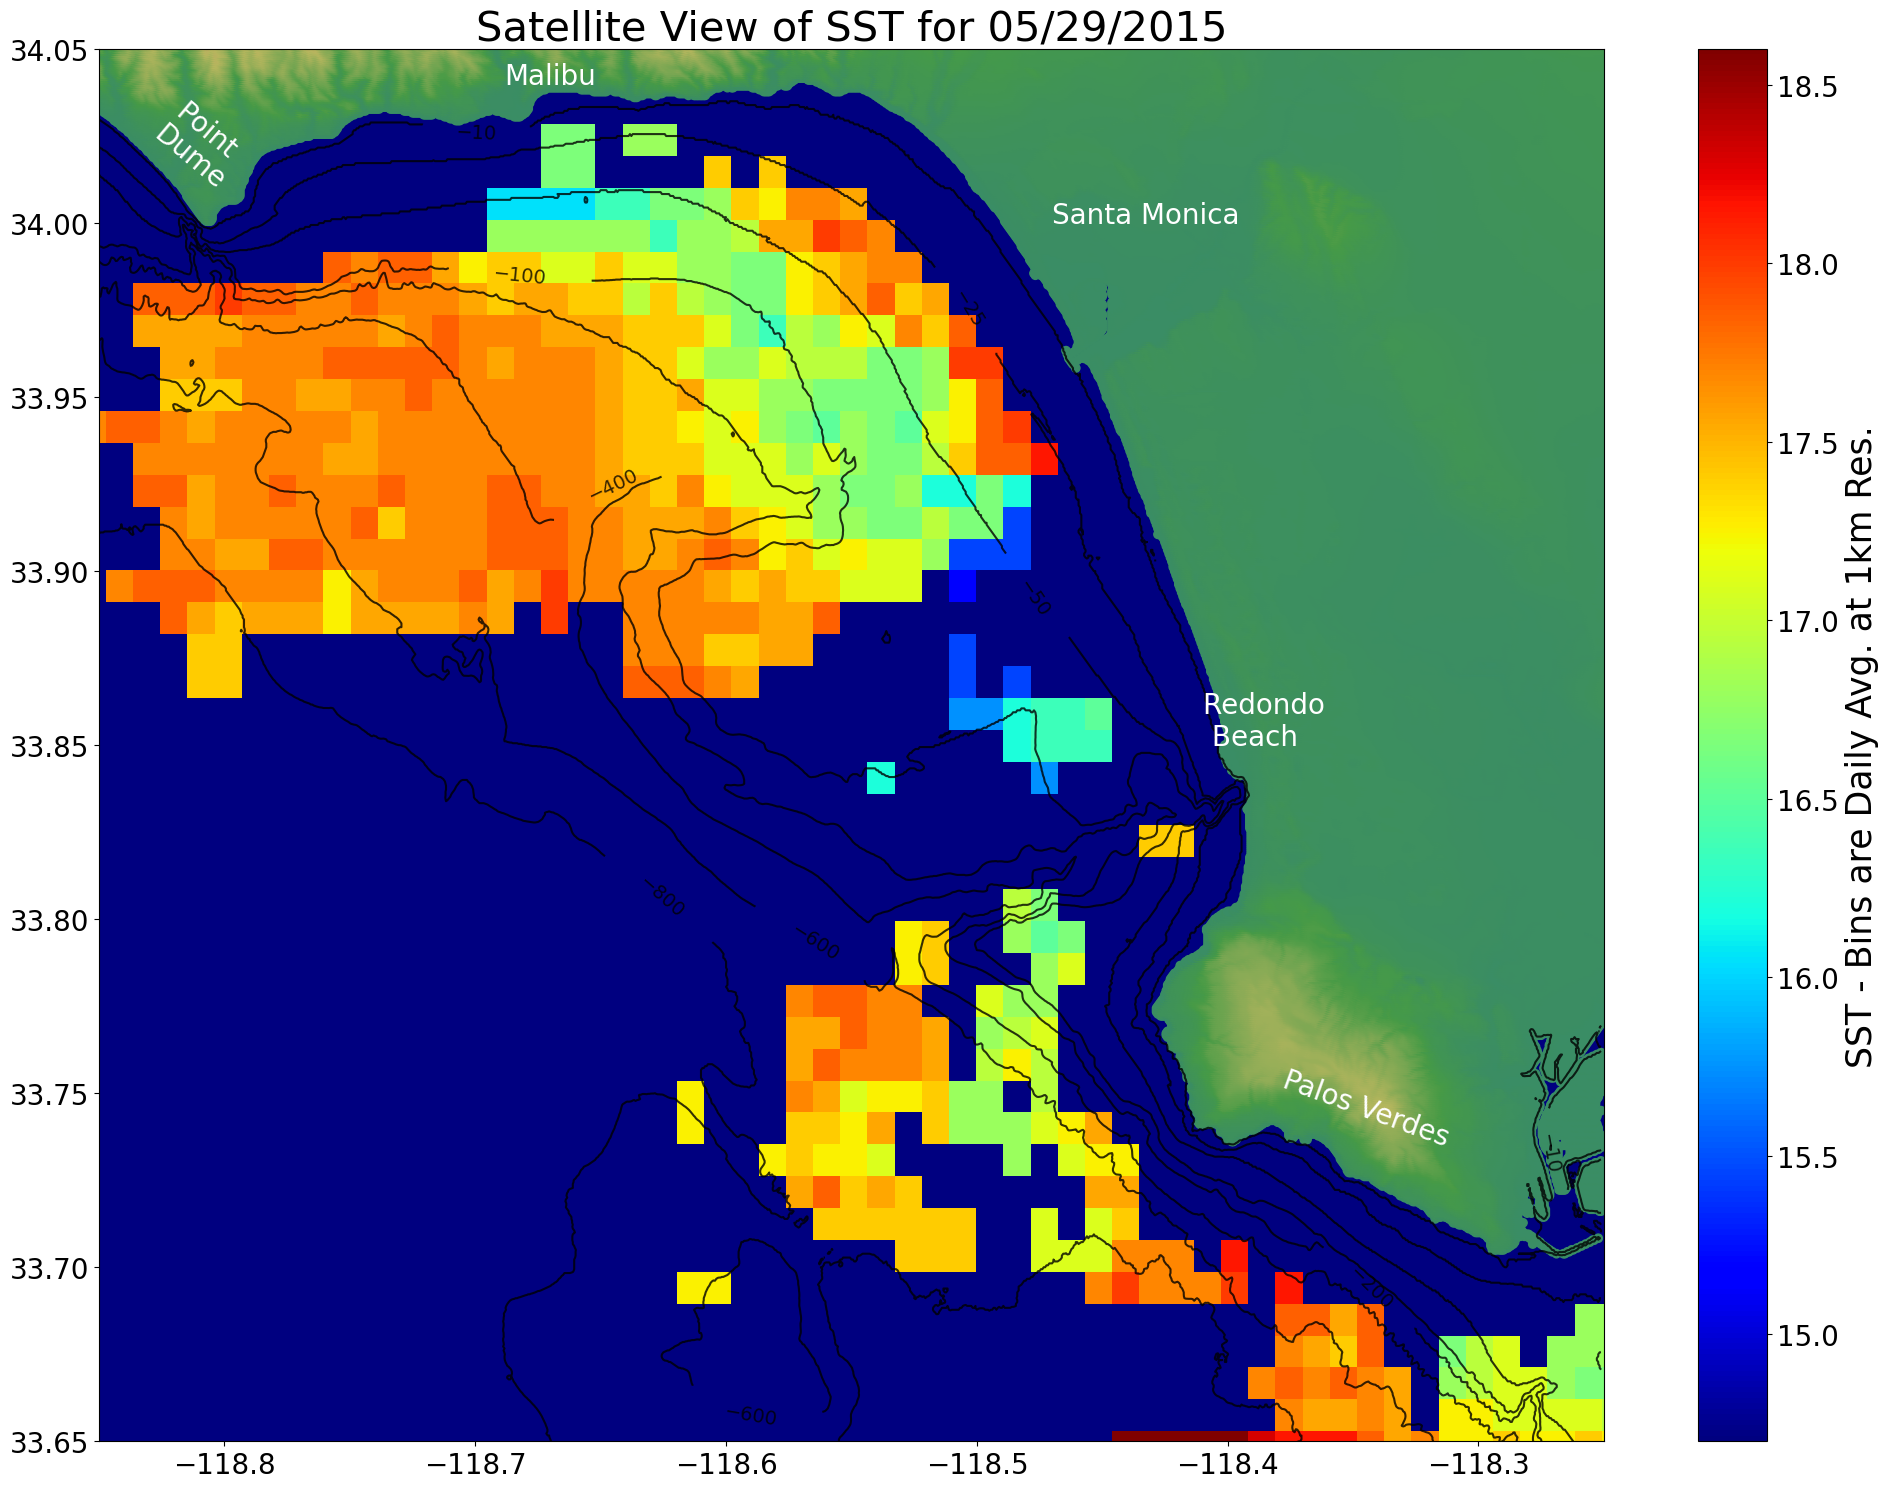

In [58]:
# ------- Temporaray File Load and Plotting ------- #

# Step 1: Download the HDF4 file using requests
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    print("File downloaded successfully!")

# Step 2: Create a temporary file to save the HDF4 content
    with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
        tmp_file.write(response.content)  # Write the downloaded file content to the temp file
        tmp_file_path = tmp_file.name     # Get the path to the temporary file

    print(f"File saved temporarily at: {tmp_file_path}", end = '\r')

    # Step 3: Open the HDF4 file from the temporary file using PyHDF
    try:
        hdf_file = SD(tmp_file_path, SDC.READ)

        # List all datasets in the file
        print("Datasets in the file:")
        datasets = hdf_file.datasets()
        for dataset_name in datasets:
            print(f"- {dataset_name}")

    except Exception as e:
        print(f"Error opening HDF file: {e}")

    # Step 4: Grab data and close file
    dataset = hdf_file.select(dataset_name)
    # Read data from the selected dataset
    data = dataset.get()
    print("Shape of data:", data.shape)
    # Close the HDF4 file after use
    hdf_file.end()

    # Step 5: Adjust from pixel values to SST
    data = data.astype(np.int16)
    # Bound to SoCal - based on indices of pixel values
    data = data[1350:1410,1780:1885]
    # Add 256 to negative values
    data[data < 0] += 256
    # Exclude pixel boundary values
    data[(data == 0) | (data == 255)] = 0
    # Adjust pixels to SST
    SST = (.15*data) - 3.0
    SST[SST == np.max(SST)] = 0

    # --- PLOTTING ---
    fig1 = plt.figure(1, (20,15))
    # Satellite Data
    if plot_track:
        sat = plt.pcolormesh(longitude, latitude[::-1], SST, cmap = 'jet', vmin = np.min(sst_filtered), vmax = np.max(sst_filtered))
    else:
        sat = plt.pcolormesh(longitude, latitude[::-1], SST, cmap = 'jet', vmin = np.min(SST[SST>0]), vmax = np.max(SST[SST>0]))
    cbar = plt.colorbar()
    if plot_track:
        cbar.set_label('SST - Bins are Daily Avg. at 1km Res. / Track at 10m Res.', fontsize = 25)
    else:
        cbar.set_label('SST - Bins are Daily Avg. at 1km Res.', fontsize = 25)
    cbar.ax.tick_params(labelsize = 20)

    if plot_track:
        # Cruise Track 
        plt.scatter(lon_sst, lat_sst, c = sst_filtered, cmap='jet', vmin=np.min(sst_filtered), vmax = np.max(sst_filtered))

    if plot_bath:
        # Bathymetric Contouts
        bathy = plt.contour(lon_bath, lat_bath, depths, [-800, -600, -400, -200, -100, -50, -25, -10], cmap='bone', vmin=-10, alpha = .8)
        plt.clabel(bathy, inline = True, fontsize = 14)

    if plot_land:
        # Land Features
        terra = plt.scatter(lon_bath[depths > 0], lat_bath[depths > 0], c = depths[depths > 0], cmap = 'gist_earth', vmin = 10)
        terra.set_clim(-500)
        # Add locations
        fs_label = 20
        plt.text(-118.81, 34.01, 'Point \nDume', fontsize=fs_label, rotation=-40, ha='center', color = 'white')
        plt.text(-118.67, 34.04, 'Malibu', fontsize=fs_label, rotation=0, ha='center', color = 'white')
        plt.text(-118.47, 34.0,  'Santa Monica', fontsize=fs_label, rotation=  0, ha='left',   color = 'white')
        plt.text(-118.41, 33.85,  'Redondo \n Beach', fontsize=fs_label, rotation=0, ha='left',color = 'white')
        plt.text(-118.345, 33.735, 'Palos Verdes', fontsize=fs_label, rotation=-20, ha='center', color = 'white')
        
    # Bounds
    plt.ylim(33.65, 34.05)
    plt.xlim(-118.85, -118.25)
    
    # Ticks
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    # Labeling 
    plt.title(f'Satellite View of SST for {month}/{day}/{year}', fontsize = 30)
        
    plt.tight_layout()
    # --- PLOTTING ---

    # Step 6: Clean up by removing the temporary file (optional)
    if os.path.exists(tmp_file_path):
        os.remove(tmp_file_path)
        print(f"Temporary file {tmp_file_path} removed.", end = '\r')


### Results

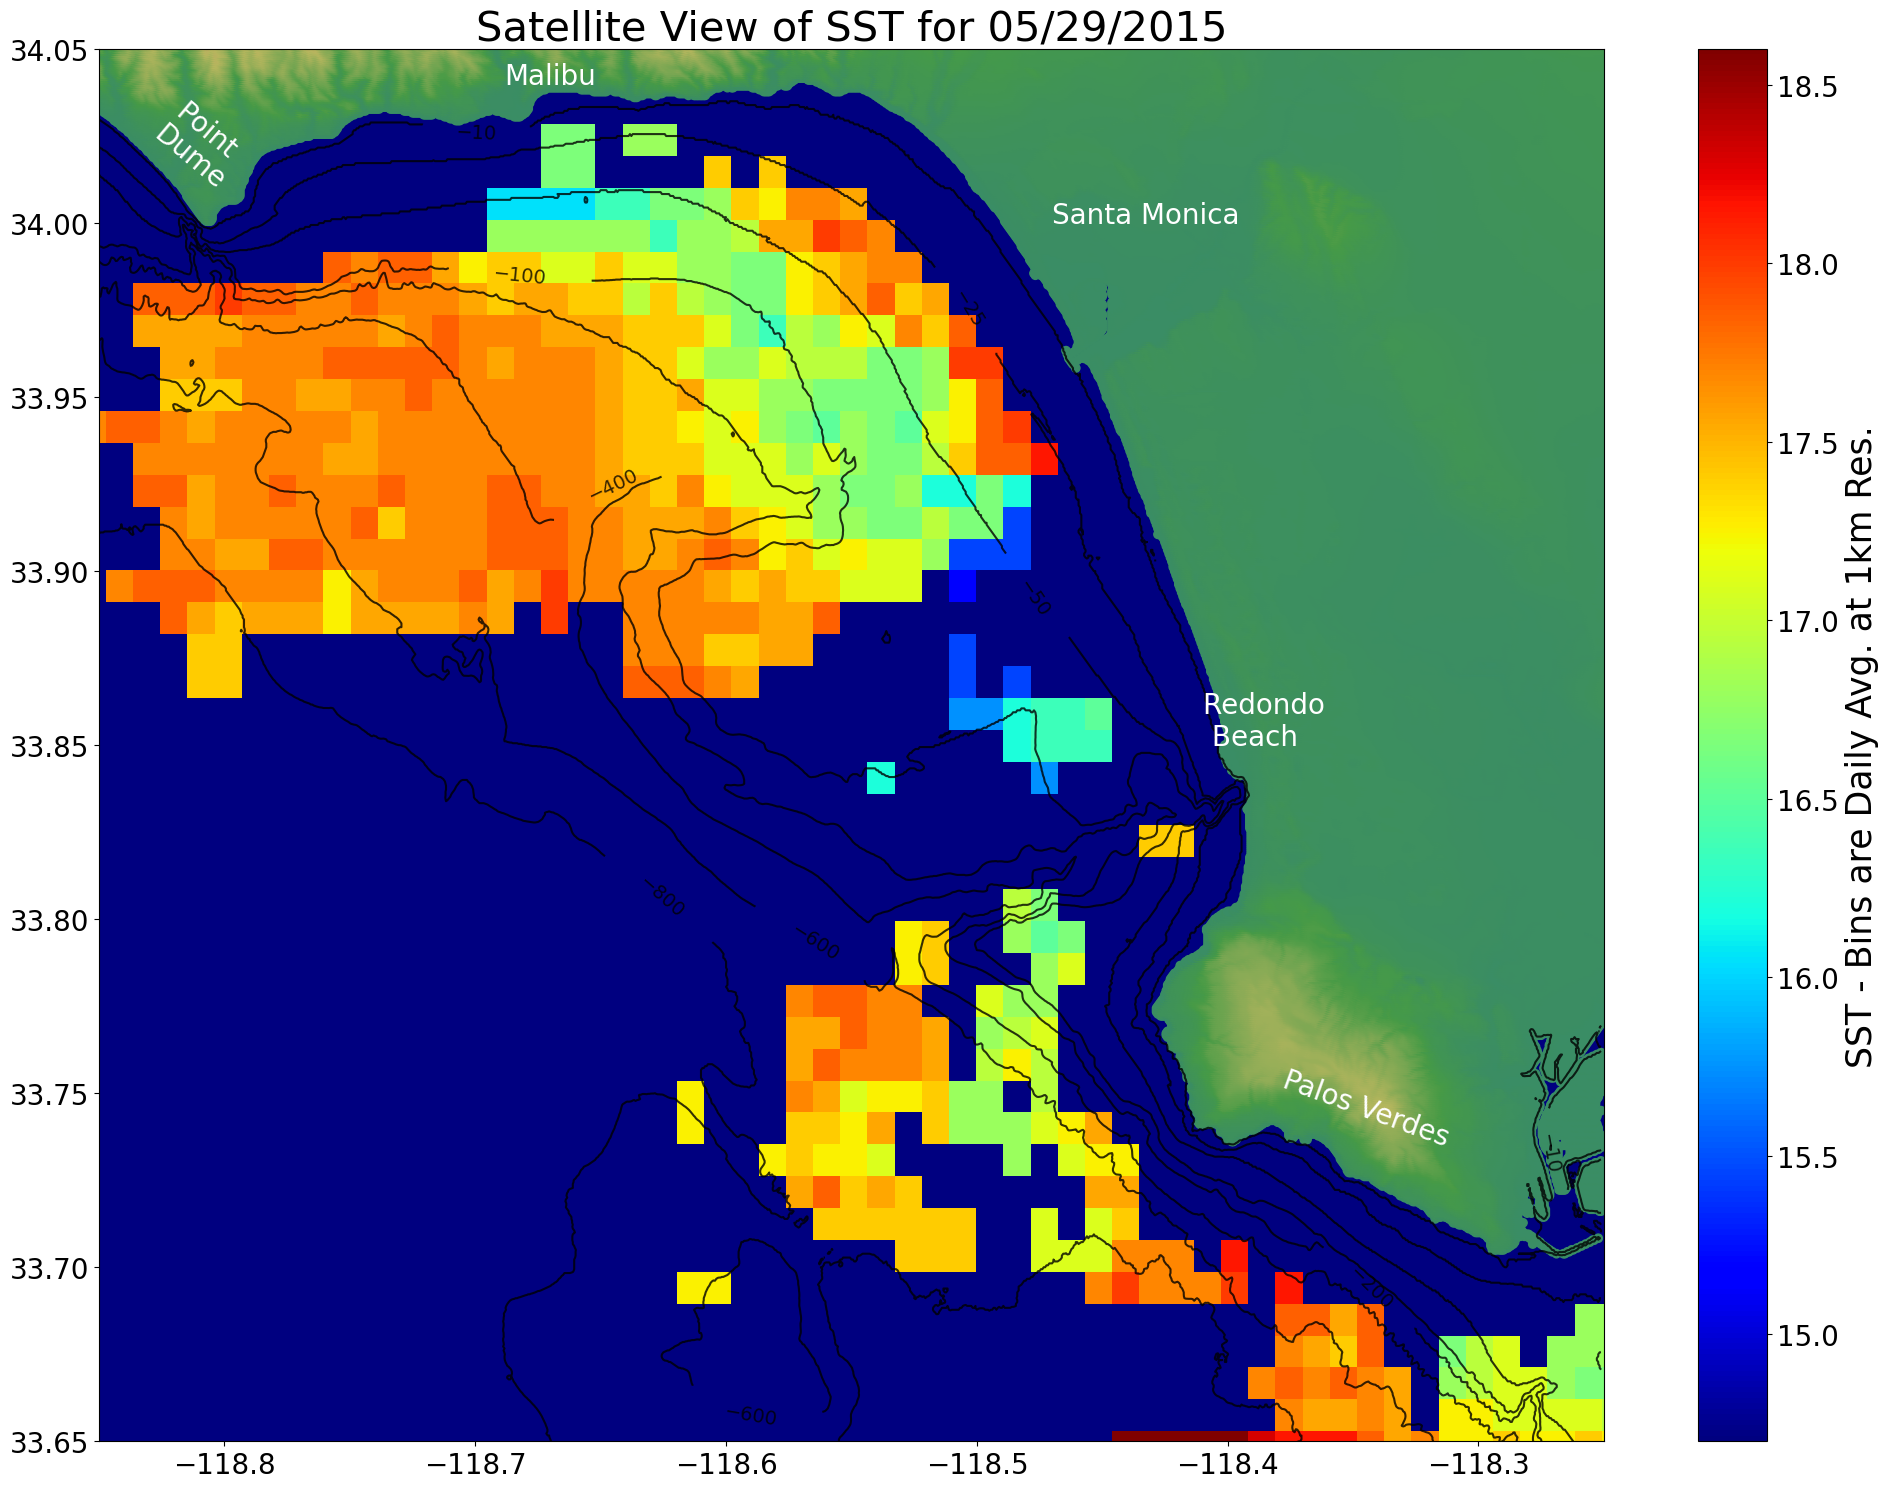

In [60]:
fig1